For this to work you need to download the "world news" corpus from https://webhose.io/datasets/ and place it in a folder, there are two zip files in there, I have been using one of them 

In [1]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [26]:
from os import listdir
from os.path import isfile, join
from pipe import *
import json
from pathlib import Path
import numpy as np

def GetFileStream(path='../worldnews-20170904'):
    # returns {(0,/path/file1), (1,/path/file2), ... }
    files = enumerate(listdir(path))
    for file in files:
        yield (file[0], join(path, file[1]))

@Pipe
def AdornFile(stream):
    # stream is {(0,filepath), (1, filepath),...}
    # return {(0,filepath1,json1), (1, filepath2,json2),...}
    for file in stream:
        yield file + (json.loads(Path(file[1]).read_text(encoding='utf-8')),)

@Pipe
def As_Npy(l):
    return np.array(list(l))

# take a filestream from AdornFile and compute a numpy matrix of embeddings
# note that this will probably get very slow if you pass more than 2000 things or so in
# as it has a quadratic time complexity, also note that nlp(t).vector is slow as hell, I 
# am investigating why
@Pipe
def ComputeNumpyEmbeddingsArrayFromStream(stream, textattrib='title'):
    return stream \
      | select( lambda j: j[2][textattrib] )     \
      | select( lambda t: nlp(t).vector )      \
      | select( lambda v: v/np.linalg.norm(v) ) \
      | As_Npy()

# this "fast" version uses the pipes API i.e. hopefully chunky not chatty to spacy API
# also vectorises the normalization, not entirely sure how slow that was but potentially
# a huge saving. Seems to give 120% speedup on 2000 docs
@Pipe
def ComputeNumpyEmbeddingsArrayFromStreamFast(stream, textattrib='title'):
    titles = stream \
      | select( lambda d: d[2][textattrib] ) \
      | as_list()
    
    M = nlp.pipe(titles) \
        | as_list() \
        | select( lambda d: d.vector ) \
        | As_Npy()
    
    return M / np.tile(np.linalg.norm(M, axis=1),(300,1)).transpose()

# later on we might need to know what a title was by its index in the self similarity matrix
def GetDocumentTextByIndex(index, field='title'):
    return GetFileStream() \
      | skip(index) \
      | take(1) \
      | AdornFile() \
      | select( lambda j: j[2][field] ) \
      | as_list()


# Orig had about 73ms seek time on index 400 which could amount to 400 seconds on 400 documents
# lets precompute a hashmap and use that to get the titles#
# first time this runs it takes about 2-3 mins on tims machine i.e. it has to parse in 30k json files
def GetDocumentTextByIndexFast(index, field='title'):
    
    global index_title_map
    
    if 'index_title_map' not in globals():
        index_title_map = GetFileStream() \
          | AdornFile() \
          | select( lambda j: ( j[0], j[2][field] ) ) \
          | as_dict()
        
    return index_title_map[index]
    

In [3]:
%%time
GetDocumentTextByIndex(500)

Wall time: 2.48 s


['Russia says warplanes hit Islamic State, denying criticism']

In [10]:
%%time
GetDocumentTextByIndexFast(500)

Wall time: 0 ns


'Russia says warplanes hit Islamic State, denying criticism'

In [27]:
# sanity check, what does our stream of files look like
GetFileStream() \
  | AdornFile() \
  | take(3) \
  | as_list()

[(0,
  '../worldnews-20170904\\news_0000001.json',
  {'organizations': [],
   'uuid': '767c7dc963d0263187da888fbfd19cd60b0bc2e8',
   'thread': {'social': {'gplus': {'shares': 0},
     'pinterest': {'shares': 0},
     'vk': {'shares': 0},
     'linkedin': {'shares': 0},
     'facebook': {'likes': 0, 'shares': 0, 'comments': 0},
     'stumbledupon': {'shares': 0}},
    'site_full': 'timesofindia.indiatimes.com',
    'main_image': 'http://timesofindia.indiatimes.com/photo/47529300.cms',
    'site_section': 'http://timesofindia.indiatimes.com/rssfeeds/1898184.cms',
    'section_title': 'China News, News in China, Latest News, Daily News | World News - Times of India',
    'url': 'http://timesofindia.indiatimes.com/world/china/China-plans-to-remove-poverty-by-2020/articleshow/49328137.cms',
    'country': 'IL',
    'title': 'China plans to remove poverty by 2020',
    'performance_score': 0,
    'site': 'indiatimes.com',
    'participants_count': 1,
    'title_full': 'China plans to remove 

Compute the matrix of glove average embeddings for some documents Seems to take 12.4 seconds for 2000 documents on Tim's laptop

In [12]:
%%time

X = GetFileStream() \
  | AdornFile()      \
  | take(1000)        \
  | ComputeNumpyEmbeddingsArrayFromStream()

X = np.nan_to_num(X)

Wall time: 6.41 s


This fast version can do 4000 records in less than half the time! 4.49 sec on tims laptop, however doing this on the full text of the articles takes 5:45 on tims laptop! important! notice how when we use the title we get good results, when we use the entire body the results are shocking. This is interesting, and somewhat unexpected. We could try some techniques to counteract this i.e. selecting the important words and averaging them

In [30]:
%%time

X = GetFileStream() \
  | AdornFile()      \
  | take(4000)        \
  | ComputeNumpyEmbeddingsArrayFromStreamFast(textattrib='title')

X = np.nan_to_num(X)

Wall time: 18.7 s


Compute the cosine similarity matrix for the embeddings matrix

In [31]:
%%time
simmatrix = np.dot(X,X.transpose())

Wall time: 115 ms


Plot the similarity matrix

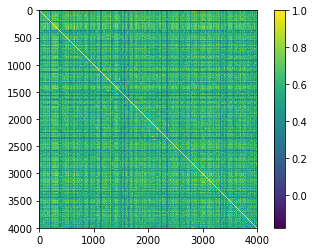

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
imgplot = plt.imshow(simmatrix)
plt.colorbar()

In [19]:
# get all the pairs of docs which are very similar, or have a cosine interval
def GetSimilarPairsDistinct( lower=0, upper=1 ):
    return ( list( np.argwhere(np.logical_and( simmatrix <upper, simmatrix >lower ))) \
    | select( lambda i: (i[0], i[1], i[1]+i[0]) ) \
    #remove a==b
    | where( lambda t: t[0] != t[1] ) \
    #distinct on the x+y i.e. remove symmetry a,b == b,a
    | groupby( lambda g: g[2] ) \
    # just take the first item in the group, and take the a,b, discard a+b
    | select( lambda g: g[1] | take(1) | select( lambda t: (t[0],t[1]) ) | as_list() ) )
            

In [25]:
%%time
# these docs are VERY similar 
( GetSimilarPairsDistinct(0.95, 1) \
| select(lambda x: ( GetDocumentTextByIndexFast(x[0][0]),GetDocumentTextByIndexFast(x[0][1]) ) ) \
# filter where the article is identical, assume they are the same thing
| where( lambda a: a[0] != a[1] ) \
| take( 100 ) \
| as_list() )

Wall time: 77 ms


[("Target advert shows girl with disabilities as Frozen's Elsa",
  'Preserving tradition with House of Mouneh | Life , Lubnan'),
 ("Target advert shows girl with disabilities as Frozen's Elsa",
  'Olympiakos bask in glory after first win on English soil | Sports , Football'),
 ("Target advert shows girl with disabilities as Frozen's Elsa",
  'Hariri to restore brother’s policy of communicating with people | News , Lebanon News'),
 ("Target advert shows girl with disabilities as Frozen's Elsa",
  'Photo Essay: Slonim Rebbe On Motzei Shabbos In Boro Park (Photos By JDN)'),
 ("Target advert shows girl with disabilities as Frozen's Elsa",
  '1948 Palestinian paraglides to Syria, allegedly to join rebels | News , Middle East'),
 ("Target advert shows girl with disabilities as Frozen's Elsa",
  'A self-portrait in Hitler’s bathtub | Arts & Ent , Culture'),
 ("Target advert shows girl with disabilities as Frozen's Elsa",
  'City top after stalemate, Klopp denied first win | Sports , Football'

Plot the distribution of cosines on this selection of documents, note the interval [0.8,1] are the ones which are very similar

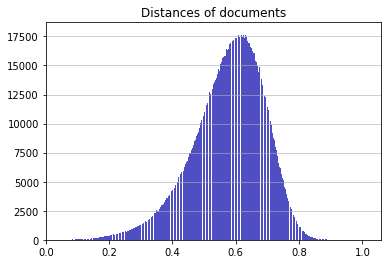

In [33]:
import matplotlib.pyplot as plt

flat_vals = simmatrix[np.triu_indices(2000)]

n, bins, patches = plt.hist(x=flat_vals, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('')
plt.ylabel('')
#plt.ylim(top=4000)
plt.xlim(left=0)
plt.title('Distances of documents')
maxfreq = n.max()

Tried this for the titles vs the full text of the articles. 

<img src="cosineplots.png" />

This seems to be showing that the more words you average, the closer every article is to every other -- which is not really what we want. One hypothesis is that we simply filter to show only important i.e. rare words and average over them instead.

Visualise the embeddings using TSNE!!

In [59]:
%%time

import numpy as np
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape


(4000, 2)

We can see from the tsne visualisation that there is some clear clustering on the articles in this selection of 2k

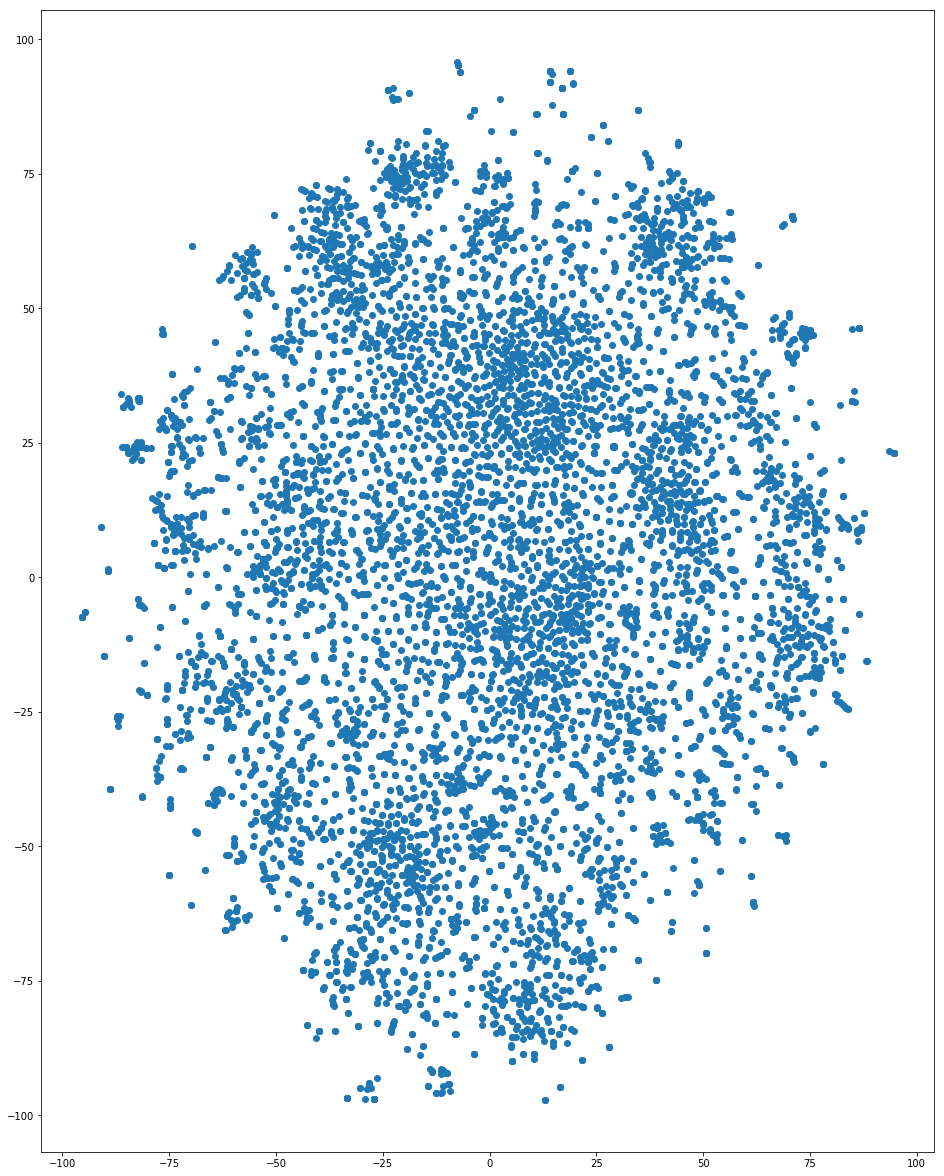

In [50]:
plt.figure(figsize=(16,21))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])

Select the events from the news articles using NER from spacy

In [30]:
%%time 

def GetEntitiesForDocIndex(index):
    return nlp(GetDocumentTextByIndex(index,'text')[0]).ents \
     | where( lambda e: e.label_=='EVENT' ) \
     | select( lambda e: (index,e.text) ) \
     | as_list()

@Pipe
def AdornEventStream(stream, filter_events_only=True): 
    return stream \
        | select(lambda d: d + (GetEntitiesForDocIndex(d[0]), )) \
        | where( lambda e: e[-1] | count() > 0 or (not filter_events_only) )

Wall time: 0 ns


In [33]:
%%time

GetFileStream()       \
  | AdornFile()        \
  | take(100)           \
  | AdornEventStream() \
  | select( lambda e: ( e[2]['title'], e[3]) ) \
  | as_list()

Wall time: 13.3 s


[('China plans to remove poverty by 2020',
  [(0, 'National Poverty Relief Day')]),
 ("Here's what 500 hot air balloons in the sky looks like",
  [(5, 'International Balloon Fiesta'),
   (5, 'International Balloon Fiesta'),
   (5, 'International Balloon Fiesta')]),
 ("Hungary's anti-migrant steps aid Orban's right-wing shift",
  [(12, 'World War II'),
   (12, 'World War II'),
   (12, 'Holocaust'),
   (12, 'World War II')]),
 ('Looking beyond the ‘third intifada’ - Opinion',
  [(19, 'Joint Comprehensive Plan of Action')]),
 ('5 things you need to know Thursday',
  [(23, 'Division Series'),
   (23, 'Game 4'),
   (23, 'Game 5'),
   (23, 'first World Series'),
   (23, 'Game 1')]),
 ('Gold Coast arts benefactor Win Schubert wins prestigious arts medal',
  [(25, 'Queensland Art Gallery')]),
 ('Lack of leadership and direction will undermine third Palestinian intifada',
  [(57, 'the Third Intifada')]),
 ('Rights group says US-backed Kurds displacing Arabs in Syria',
  [(68, 'the civil war')])

Clustering approachm notice how we get much better results on euclidean distance, this makes me think we got something wrong with the normalization of the word features

In [84]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

model = AgglomerativeClustering(n_clusters=10,linkage='ward', affinity='euclidean')
model.fit(X)


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=10,
            pooling_func=<function mean at 0x000001E8AA6EB6A8>)

Text(0.5,1,'Clustering of news articles')

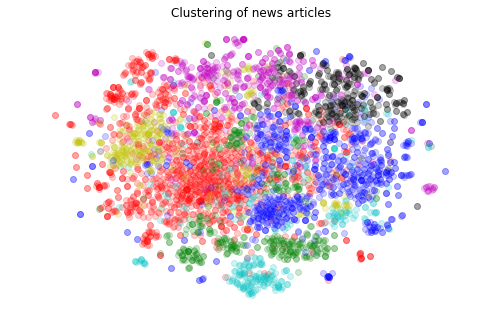

In [91]:
plt.figure()
plt.axes([0, 0, 1, 1])
for l, c in zip(np.arange(model.n_clusters), 'rgbkmcyrgb'):
    plt.scatter(X_embedded[model.labels_ == l][:, 0], X_embedded[model.labels_ == l][:, 1], c=c, alpha=.2)
    
plt.axis('tight')
plt.axis('off')
plt.title("Clustering of news articles")

In [66]:
X_embedded[44]

array([-45.79846 ,   6.202497], dtype=float32)

In [55]:
zip(np.arange(model.n_clusters), 'rgbk') | as_list()

[(0, 'r'), (1, 'g'), (2, 'b'), (3, 'k')]

In [57]:
model.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [47]:
C = model.fit_predict(X)

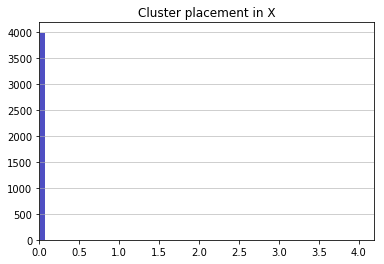

In [53]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(x=C, bins=50, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('')
plt.ylabel('')
#plt.ylim(top=4000)
plt.xlim(left=0)
plt.title('Cluster placement in X')
maxfreq = n.max()